In [1]:
import seaborn as sns
import pandas as pd
import os
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    make_scorer,
)
from skopt import BayesSearchCV

In [2]:
three_state = pd.read_csv("training_and_test_data/three_state.csv")
three_state = three_state.drop(columns=["Unnamed: 0"])
three_state.head()

,I1,Q1,I2,Q2,label
0,-1219.981331,-1108.886181,2829.464497,5469.440894,1
1,1731.917859,-2057.339620,-848.292881,4454.632494,0
2,-2685.988013,-1617.022457,-1358.464775,4351.102532,2
3,-107.365457,-2364.224230,-1734.700961,5955.748518,0
4,1017.745420,-1726.000591,2560.349651,5923.291019,1


In [3]:
# Define features (X) and labels (y)
X = three_state.drop(columns=["label"])  # All columns except "label"
y = three_state["label"]  # Target labels

# Split into 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [4]:
precision_scorer = make_scorer(precision_score, average="weighted")
# Initialize LightGBM model with default parameters
lgbm = lgb.LGBMClassifier(objective="multiclass", num_class=3, n_jobs=-1)

# hyperparameter tuning
param_serach = {
    "num_leaves": (20, 40),
    "learning_rate": (0.05, 0.3, "log-uniform"),
    "n_estimators": (50, 250),
    "max_depth": (2, 15),
    "min_child_samples": (10, 80),
    "subsample": (0.5, 1.0, "uniform"),
    "colsample_bytree": (0.1, 1.0, "uniform"),
}

cv = StratifiedKFold(n_splits=5, shuffle=True)

bayes_search = BayesSearchCV(
    estimator=lgbm,
    search_spaces=param_serach,
    n_iter=20,
    scoring=precision_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=0,
)

bayes_search.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 720000, number of used features: 4
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
              estimator=LGBMClassifier(n_jobs=-1, num_class=3,
                                       objective='multiclass'),
              n_iter=20, n_jobs=-1,
              scoring=make_scorer(precision_score, response_method='predict', average=weighted),
              search_spaces={'colsample_bytree': (0.1, 1.0, 'uniform'),
                             'learning_rate': (0.05, 0.3, 'log-uniform'),
                             'max_depth': (2, 15),
                             'min_child_samples': (10, 80),
                             'n_estimators': (50, 250), 'num_leaves': (20, 40),
                             'subsample': (0.5, 1.0, 'uniform')})

In [5]:
# Train the model on full training data
best_lgbm = bayes_search.best_estimator_
best_lgbm.fit(X_train, y_train)

# Predict on test set
y_pred = best_lgbm.predict(X_test)

# Compute accuracy
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred, average="weighted")
conf_matrix = confusion_matrix(y_test, y_pred, normalize="true")
print(f"Best Hyperparameters: {bayes_search.best_params_}")
print(f"Best CV Score: {bayes_search.best_score_:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(conf_matrix)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 720000, number of used features: 4
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Best Hyperparameters: OrderedDict({'colsample_bytree': 0.4401336980867453, 'learning_rate': 0.06894496376292093, 'max_depth': 6, 'min_child_samples': 70, 'n_estimators': 188, 'num_leaves': 28, 'subsample': 0.5185106861307768})
Best CV Score: 0.8822
Test Precision: 0.8818
Test Accuracy: 0.8672
[[0.96513333 0.00563333 0.02923333]
 [0.14921667 0.8369     0.01388333]
 [0.14105    0.05938333 0.79956667]]


In [6]:
import joblib

# save model
joblib.dump(best_lgbm, "lgb.pkl")

['lgb.pkl']

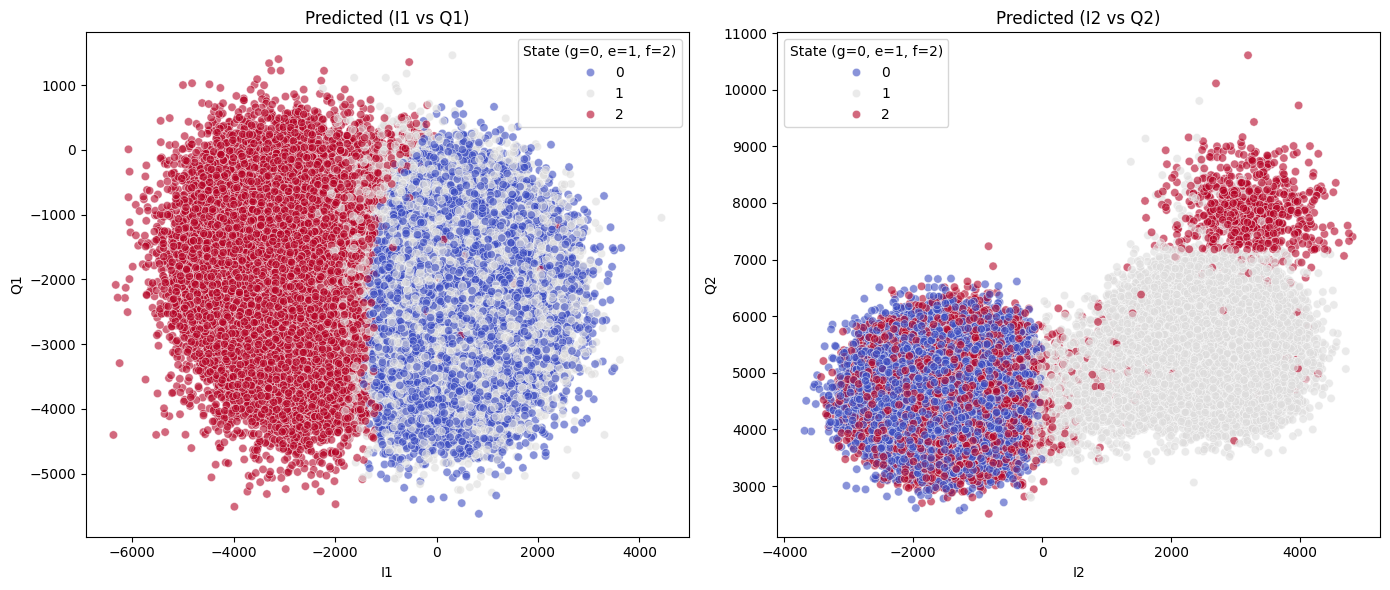

In [7]:
# Convert test data into a DataFrame for easier plotting
test_df = pd.DataFrame(X_test, columns=["I1", "Q1", "I2", "Q2"])
test_df["label"] = y_test  # Add true labels
test_df["predicted"] = y_pred  # Add predicted labels

# Create subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First subplot: I1 vs Q1
sns.scatterplot(
    data=test_df,
    x="I1",
    y="Q1",
    hue="predicted",
    palette="coolwarm",
    alpha=0.6,
    ax=axes[0],
)
axes[0].set_xlabel("I1")
axes[0].set_ylabel("Q1")
axes[0].set_title("Predicted (I1 vs Q1)")
axes[0].legend(title="State (g=0, e=1, f=2)")

# Second subplot: I2 vs Q2
sns.scatterplot(
    data=test_df,
    x="I2",
    y="Q2",
    hue="predicted",
    palette="coolwarm",
    alpha=0.6,
    ax=axes[1],
)
axes[1].set_xlabel("I2")
axes[1].set_ylabel("Q2")
axes[1].set_title("Predicted (I2 vs Q2)")
axes[1].legend(title="State (g=0, e=1, f=2)")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

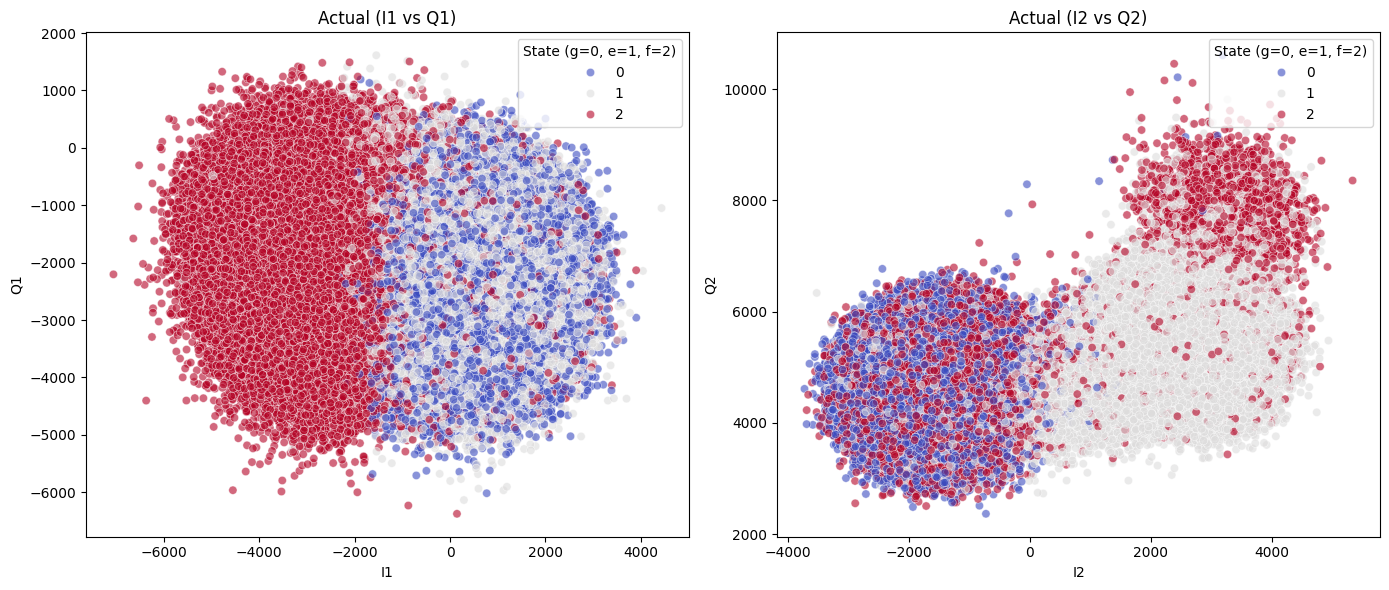

In [8]:
# Create subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First subplot: I1 vs Q1
sns.scatterplot(
    data=three_state,
    x="I1",
    y="Q1",
    hue="label",
    palette="coolwarm",
    alpha=0.6,
    ax=axes[0],
)
axes[0].set_xlabel("I1")
axes[0].set_ylabel("Q1")
axes[0].set_title("Actual (I1 vs Q1)")
axes[0].legend(title="State (g=0, e=1, f=2)", loc="upper right")

# Second subplot: I2 vs Q2
sns.scatterplot(
    data=three_state,
    x="I2",
    y="Q2",
    hue="label",
    palette="coolwarm",
    alpha=0.6,
    ax=axes[1],
)
axes[1].set_xlabel("I2")
axes[1].set_ylabel("Q2")
axes[1].set_title("Actual (I2 vs Q2)")
axes[1].legend(title="State (g=0, e=1, f=2)", loc="upper right")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

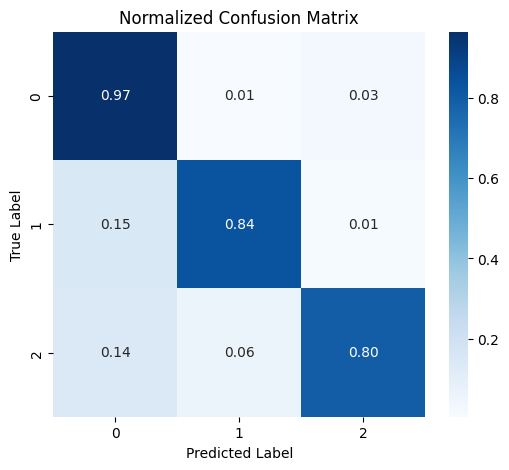

In [9]:
plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=[0, 1, 2],
    yticklabels=[0, 1, 2],
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.show()

In [10]:
import numpy as np

np.linalg.inv(conf_matrix)

array([[ 1.04235242, -0.00431745, -0.03803497],
       [-0.18302331,  1.19711796, -0.01409464],
       [-0.17028633, -0.08814759,  1.25843393]])

In [11]:
np.linalg.inv(
    [
        [1.02181452, -0.01073271, -0.01108182],
        [-0.22394639, 1.26065883, -0.03671244],
        [-0.20113232, -0.11916995, 1.32030227],
    ]
)

array([[0.98233334, 0.00916667, 0.0085    ],
       [0.17933333, 0.797     , 0.02366667],
       [0.16583333, 0.07333333, 0.76083334]])